In [1]:
from data.data_loader import data_preprocess, get_data_1, get_data_2, get_data_3, get_data_4
from utils.tools import EarlyStopping, save_exp_result, load_exp_result
from utils.tools import plot_metric, plot_loss_variation, plot_metric_variation
from utils.metrics import test_metric
from models.model import Transformer
from core.exp_transformer import train, validate, test, predict, inference_test, inference_predict, inference_predict_only_label

import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime, timedelta
from dateutil.parser import parse
import yfinance as yf
yf.pdr_override()

import argparse
import openpyxl as opx
import xlrd
import time
import math
import seaborn as sns
import random
from copy import deepcopy
from pytimekr import pytimekr

from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import font_manager, rc
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline
plt.rc("font", family = "Malgun Gothic")


# Data

In [4]:
tesla = pdr.get_data_yahoo('TSLA')

[*********************100%***********************]  1 of 1 completed


In [6]:
# 종가만 활용
df = tesla[['Close']]

In [7]:
capacity = max(df['Close'])

In [8]:
prep = data_preprocess(df, tgt_column='Close', train_ratio=0.7, test_ratio=0.1)

In [9]:
train_data, val_data, test_data = prep.preprocess()

In [10]:
print(train_data.shape, val_data.shape,test_data.shape)

(2207, 6) (631, 6) (315, 6)


In [ ]:
# input_window = 4
# output_window = 2
# stride = 1
# train_set = get_data_3(val_data, input_window, output_window)
# val_set = get_data_3(val_data, input_window, output_window)
# test_set = get_data_3(test_data, input_window, output_window)
# partition = {'train':train_set, 'val':val_set, 'test':test_set}

In [13]:
# train_loader = DataLoader(partition['train'], batch_size=256, shuffle=True, num_workers=0)
# val_loader = DataLoader(partition['val'], batch_size=1, shuffle=False, num_workers=0)

In [14]:
# for data in val_loader:
#     src, tgt, tgt_y = data
#     print(src, tgt, tgt_y)
#     print(src.shape, tgt.shape, tgt_y.shape)

tensor([[[0.3333, 0.1613, 0.0000, 0.5714, 0.0000, 0.8547],
         [0.3333, 0.2581, 0.0000, 0.0000, 0.0000, 0.8395],
         [0.3333, 0.2903, 0.0000, 0.1429, 0.0000, 0.8318],
         [0.3333, 0.3226, 0.0000, 0.2857, 0.0000, 0.8642]]]) tensor([[[0.3333, 0.3548, 0.0000, 0.4286, 0.0000],
         [0.3333, 0.3871, 0.0000, 0.5714, 0.0000]]]) tensor([[[0.7981],
         [0.7918]]])
torch.Size([1, 4, 6]) torch.Size([1, 2, 5]) torch.Size([1, 2, 1])
tensor([[[0.3333, 0.2581, 0.0000, 0.0000, 0.0000, 0.8395],
         [0.3333, 0.2903, 0.0000, 0.1429, 0.0000, 0.8318],
         [0.3333, 0.3226, 0.0000, 0.2857, 0.0000, 0.8642],
         [0.3333, 0.3548, 0.0000, 0.4286, 0.0000, 0.7981]]]) tensor([[[0.3333, 0.3871, 0.0000, 0.5714, 0.0000],
         [0.3333, 0.4839, 0.0000, 0.0000, 0.0000]]]) tensor([[[0.7918],
         [0.7804]]])
torch.Size([1, 4, 6]) torch.Size([1, 2, 5]) torch.Size([1, 2, 1])
tensor([[[0.3333, 0.2903, 0.0000, 0.1429, 0.0000, 0.8318],
         [0.3333, 0.3226, 0.0000, 0.2857, 0.0

tensor([[[ 0.8333,  0.1935,  0.0000,  0.1429,  0.0000, 16.4010],
         [ 0.8333,  0.2258,  0.0000,  0.2857,  0.0000, 16.8913],
         [ 0.8333,  0.2581,  0.0000,  0.4286,  0.0000, 16.9181],
         [ 0.8333,  0.2903,  0.0000,  0.5714,  0.0000, 17.2680]]]) tensor([[[0.8333, 0.3871, 0.0000, 0.0000, 1.0000],
         [0.8333, 0.4194, 0.0000, 0.1429, 0.0000]]]) tensor([[[17.6275],
         [17.8158]]])
torch.Size([1, 4, 6]) torch.Size([1, 2, 5]) torch.Size([1, 2, 1])
tensor([[[ 0.8333,  0.2258,  0.0000,  0.2857,  0.0000, 16.8913],
         [ 0.8333,  0.2581,  0.0000,  0.4286,  0.0000, 16.9181],
         [ 0.8333,  0.2903,  0.0000,  0.5714,  0.0000, 17.2680],
         [ 0.8333,  0.3871,  0.0000,  0.0000,  1.0000, 17.6275]]]) tensor([[[0.8333, 0.4194, 0.0000, 0.1429, 0.0000],
         [0.8333, 0.4516, 0.0000, 0.2857, 0.0000]]]) tensor([[[17.8158],
         [18.4503]]])
torch.Size([1, 4, 6]) torch.Size([1, 2, 5]) torch.Size([1, 2, 1])
tensor([[[ 0.8333,  0.2581,  0.0000,  0.4286,  0.000

# Experiment

## Experimental block

In [ ]:
def experiment(partition, args):
  
    model = Transformer(args.encoding_length, args.decoding_length, args.d_model, args.enc_in_features, args.dec_in_features, args.out_features, args.n_heads, args.n_layers, args.dim_feedforward, args.dropout)
    model.cuda()

    criterion = nn.MSELoss()
    criterion.cuda()    
    
    if args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
    elif args.optim == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.l2)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = [] # s 붙은건 list 나타내기 위함 
    val_losses = []
    train_metrics = []
    val_metrics = []
    # ===================================== #
    
    early_stopping = EarlyStopping(patience = args.early_stopping_patience, verbose = True)
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_metric = train(model, partition, optimizer, criterion, args)
        val_loss, val_metric = validate(model, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_metrics.append(train_metric)
        val_metrics.append(val_metric)
        # ============================ #
        
        print('Epoch {}, Metric(train/val): {:2.4f}/{:2.4f}, Loss(train/val) {:2.4f}/{:2.4f}. Took {:2.2f} sec'.format(epoch, train_metric, val_metric, train_loss, val_loss, te-ts))
        scheduler.step()    
        
        # ==== Early_stopping은 validation metric이 감소하였는지 체크, 만약 감소하였을 경우 현재 모델을 checkpoint로 생성 == #    
        early_stopping(val_metric, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    test_metric = test(model, partition, args)
    
    # ==== Best case가 저장되어 있는 last checkpoint 로드 (callback)
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_metrics'] = train_metrics
    result['val_metrics'] = val_metrics
    result['train_metric'] = train_metric
    result['val_metric'] = val_metric
    result['test_metric'] = test_metric
    return vars(args), result #args를 vars로 감싸면 dictionary가 됨 
    # ===================================== #

## Testing the hyperparameters

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
parser = argparse.ArgumentParser()
args = parser.parse_args("")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
args.exp_name = 'exp1_n_head_dim_feedforward'

# ===== Transformer model capacity ==== #
args.d_model = 128
args.n_heads = 4
args.n_layers = 3
args.enc_in_features = 6 # 인코더 src in 피쳐개수
args.dec_in_features = 6 # 디코더 tgt in 피쳐개수
args.out_features = 1 # decoder output 피쳐개수
args.dim_feedforward = 128
args.encoding_length = 48
args.decoding_length = 24

# ==== Transformer regularization ==== #
args.dropout = 0.05
args.l2 = 0

# ==== Optimizer & Training ====#
args.use_amp = True
args.optim = 'Adam'
args.gamma = 0.95
args.lr = 0.0005
args.epoch = 3
args.batch_size = 64
args.early_stopping_patience = 50

# ====== Experiment Variable ====== #
name_var1 = 'n_head'
name_var2 = 'dim_feedforward'
list_var1 = [1,2]
list_var2 = [128,256]

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1) # 실험변수명 자동화 처리 되도록 하는 구문, string attribute 값 지정되면 그 항목값으로 지정 
        setattr(args, name_var2, var2)
        print(args)        
        # ====== Data ======== #
        input_window = args.encoding_length # 예측을 위해 참고할 과거 time-step
        output_window = args.decoding_length # 예측할 미래 time-step                
        train_set = get_data(train_data, input_window, output_window)
        val_set = get_data(val_data, input_window, output_window)
        test_set = get_data(test_data, input_window, output_window)
        partition = {'train':train_set, 'val':val_set, 'test':test_set}
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

## Result posting

In [ ]:
var1 = 'n_head'
var2 = 'dim_feedforward'
df = load_exp_result('exp1')

plot_metric(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=True) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_metric_variation(var1, var2, df, margin_titles=True, sharey=True)

# Exclusive training

## Hyperparameters

In [15]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ===== Transformer model capacity ==== #
args.d_model = 128
args.n_heads = 4
args.n_layers = 3
args.enc_in_features = 6 # 인코더 src in 피쳐개수
args.dec_in_features = 1 # 디코더 tgt in 피쳐개수
args.out_features = 1 # decoder output 피쳐개수
args.dim_feedforward = 128
args.encoding_length = 5
args.decoding_length = 5

# ==== Transformer regularization ==== #
args.dropout = 0.05
args.l2 = 0

# ==== Optimizer & Training ====#
args.use_amp = True
args.optim = 'Adam'
args.lr = 0.0005
args.epoch = 20
args.gamma = 0.95
args.batch_size = 32
args.early_stopping_patience = 5
args.get_data = get_data_2

# ====== Data ======== #
input_window = args.encoding_length # 예측을 위해 참고할 과거 time-step
output_window = args.decoding_length # 예측할 미래 time-step

train_set = args.get_data(train_data, input_window, output_window)
val_set = args.get_data(val_data, input_window, output_window)
test_set = args.get_data(test_data, input_window, output_window)
partition = {'train':train_set, 'val':val_set, 'test':test_set}

print(args)
test_model = Transformer(args.encoding_length, args.decoding_length, args.d_model, args.enc_in_features, args.dec_in_features, args.out_features, args.n_heads, args.n_layers, args.dim_feedforward, args.dropout)
test_model.cuda()

criterion = nn.MSELoss() # Loss function
criterion.cuda()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

if args.optim == 'RMSprop':
    optimizer = optim.RMSprop(test_model.parameters(), lr=args.lr, weight_decay=args.l2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
elif args.optim == 'Adam':
    optimizer = optim.Adam(test_model.parameters(), lr=args.lr, weight_decay=args.l2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
elif args.optim == 'AdamW':
    optimizer = optim.AdamW(test_model.parameters(), lr=args.lr, weight_decay=args.l2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=args.gamma)
else:
    raise ValueError('In-valid optimizer choice')

Namespace(batch_size=32, d_model=128, dec_in_features=1, decoding_length=5, dim_feedforward=128, dropout=0.05, early_stopping_patience=5, enc_in_features=6, encoding_length=5, epoch=20, gamma=0.95, get_data=<class 'data.data_loader.get_data_2'>, l2=0, lr=0.0005, n_heads=4, n_layers=3, optim='Adam', out_features=1, use_amp=True)


## Run

In [16]:
# ===== List for epoch-wise data ====== #
train_losses = [] # s 붙은건 list 나타내기 위함 
val_losses = []
train_metrics = []
val_metrics = []
# ===================================== #

# ==== Early stopping object 초기화 ====#
early_stopping = EarlyStopping(patience = args.early_stopping_patience, verbose = True)

for epoch in range(args.epoch):  # loop over the dataset multiple times
    ts = time.time()
    test_model, train_loss, train_metric = train(test_model, partition, optimizer, criterion, args)
    val_loss, val_metric = validate(test_model, partition, criterion, args)
    te = time.time()

    # ====== Add Epoch Data ====== #
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_metrics.append(train_metric)
    val_metrics.append(val_metric)
    # ============================ #
    print('Epoch {}, Metric(train/val): {:2.4f}/{:2.4f}, Loss(train/val) {:2.6f}/{:2.6f}. Took {:2.2f} sec'.format(epoch, train_metric, val_metric, train_loss, val_loss, te-ts))
    
    # ==== Early_stopping은 validation metric이 감소하였는지 체크, 만약 감소하였을 경우 현재 모델을 checkpoint로 생성 == #
    
    early_stopping(val_metric, test_model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

# ==== Best case가 저장되어 있는 last checkpoint 로드 (callback)
test_model.load_state_dict(torch.load('checkpoint.pt'))


Epoch 0, Metric(train/val): 18.4402/105.6993, Loss(train/val) 0.188722/252.836415. Took 4.68 sec
Validation metric decreased (inf --> 105.699279).  Saving model ...
Epoch 1, Metric(train/val): 7.9278/105.5804, Loss(train/val) 0.014738/251.090502. Took 2.71 sec
Validation metric decreased (105.699279 --> 105.580402).  Saving model ...
Epoch 2, Metric(train/val): 7.4727/105.1928, Loss(train/val) 0.013016/247.530188. Took 2.58 sec
Validation metric decreased (105.580402 --> 105.192800).  Saving model ...
Epoch 3, Metric(train/val): 6.6639/105.6722, Loss(train/val) 0.010324/250.614728. Took 2.60 sec
EarlyStopping counter: 1 out of 5
Epoch 4, Metric(train/val): 6.5674/106.3808, Loss(train/val) 0.010163/255.902911. Took 2.57 sec
EarlyStopping counter: 2 out of 5
Epoch 5, Metric(train/val): 6.1285/106.1472, Loss(train/val) 0.008651/256.510730. Took 2.66 sec
EarlyStopping counter: 3 out of 5
Epoch 6, Metric(train/val): 6.0030/107.2034, Loss(train/val) 0.008318/258.147030. Took 2.71 sec
EarlySt

<All keys matched successfully>

## test

In [17]:
test(test_model, partition, args, capacity=capacity)

test shape: (9, 32, 5, 1) (9, 32, 5, 1)
test shape: (288, 5, 1) (288, 5, 1)
mse:64977.9408, mae:248.8021, Cv_rmse:89.1077, kr_error:60.6879, mape:0.8644, mspe:0.7479


## Save the model

In [ ]:
torch.save(test_model.state_dict(), "./weights/iitp_tf_3.pth")

# Pred 

In [ ]:
test_model.load_state_dict(torch.load("./weights/iitp_tf_4.pth"))

In [18]:
y_pred, y_true = predict(test_model, partition, args)

In [ ]:
y_pred, y_true = inference_predict(test_model, partition, args)

In [ ]:
y_pred, y_true = inference_predict_only_label(test_model, partition, args)

In [ ]:
np.savez('./results/tf_case2_inf', y_pred=y_pred, y_true=y_true)

In [ ]:
np_savez_load=np.load('./results/tf_case1_inf.npz')

In [ ]:
y_pred=np_savez_load['y_pred']
y_true=np_savez_load['y_true']

In [19]:
mae,mse,Cv_rmse,kr_error, mape,mspe = test_metric(y_pred[:,:,-1], y_true[:,:,-1], capacity)
print(mae, mse, Cv_rmse, kr_error)

240.92008708209474 62028.27972011271 89.53068860258934 58.765296574077354


In [20]:
y_pred.shape

(305, 5, 1)

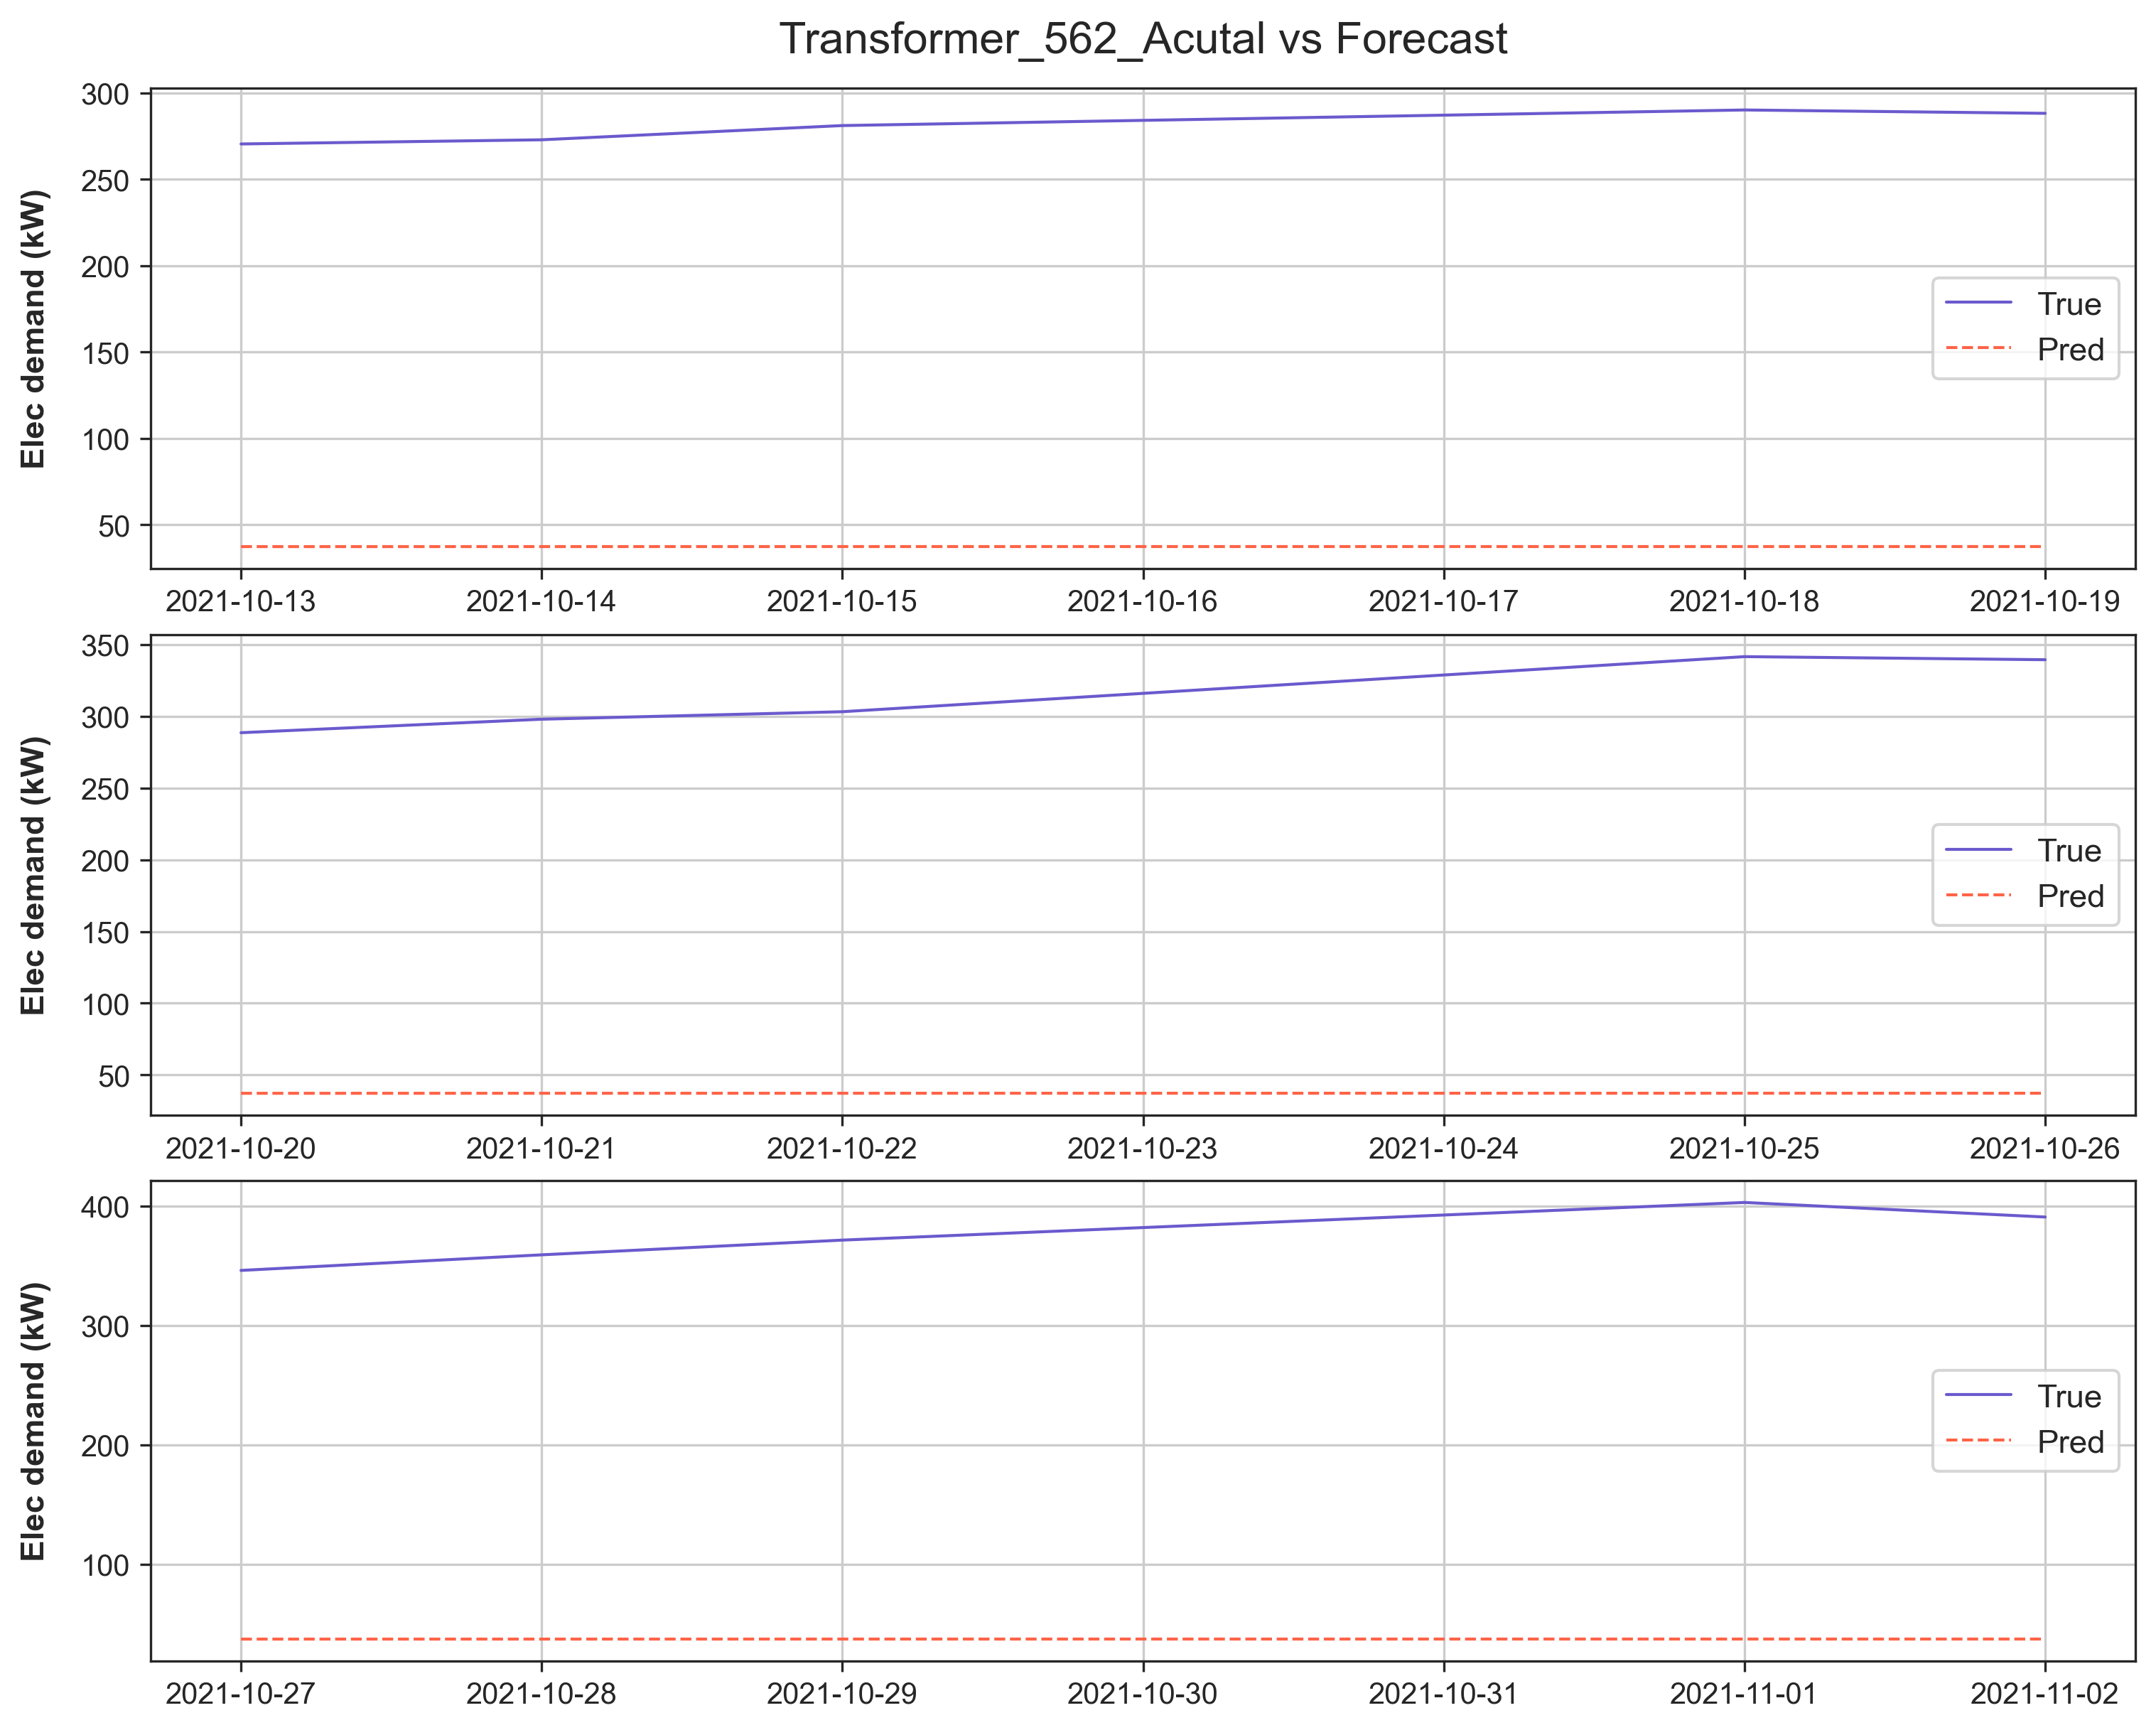

In [23]:
sns.set_style('ticks')
tick_labelsize=10
legend_fontsize=11
label_fontsize=11
fig_hor = 10
fig_time_step = 0
x_index1=df.iloc[len(df)-len(test_data)+args.encoding_length:].index[fig_time_step + args.decoding_length*0 : args.decoding_length*1+fig_time_step]
x_index2=df.iloc[len(df)-len(test_data)+args.encoding_length:].index[fig_time_step + args.decoding_length*1 : args.decoding_length*2+fig_time_step]
x_index3=df.iloc[len(df)-len(test_data)+args.encoding_length:].index[fig_time_step + args.decoding_length*2 : args.decoding_length*3+fig_time_step]


fig = plt.figure(figsize=(fig_hor,8), constrained_layout=True, dpi=300) # 가로 x 세로

ax1 = fig.add_subplot(3,1,1)
ax1.plot(x_index1, y_true[:,:,-1][fig_time_step+args.decoding_length*0], color = 'slateblue', label='True', lw = 1.0, alpha=1.0)
ax1.plot(x_index1, y_pred[:,:,-1][fig_time_step+args.decoding_length*0], color = 'tomato', label='Pred', lw = 1.0, alpha=1.0, linestyle='--')
ax1.set_ylabel('Elec demand (kW)', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('Transformer_562_Acutal vs Forecast', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
# ax1.set_ylim(25, 105)
ax1.grid()

ax2 = fig.add_subplot(3,1,2)
ax2.plot(x_index2, y_true[:,:,-1][fig_time_step+args.decoding_length*1], color = 'slateblue', label='True', lw = 1.0, alpha=1.0)
ax2.plot(x_index2, y_pred[:,:,-1][fig_time_step+args.decoding_length*1], color = 'tomato', label='Pred', lw = 1.0, alpha=1.0, linestyle='--')
ax2.set_ylabel('Elec demand (kW)', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax2.tick_params(axis='x', labelsize=tick_labelsize)
ax2.tick_params(axis='y', labelsize=tick_labelsize)
ax2.legend(loc='best', fontsize=legend_fontsize)
# ax2.set_ylim(25, 105)
ax2.grid()

ax3 = fig.add_subplot(3,1,3)
ax3.plot(x_index3, y_true[:,:,-1][fig_time_step+args.decoding_length*2], color = 'slateblue', label='True', lw = 1.0, alpha=1.0)
ax3.plot(x_index3, y_pred[:,:,-1][fig_time_step+args.decoding_length*2], color = 'tomato', label='Pred', lw = 1.0, alpha=1.0, linestyle='--')
ax3.set_ylabel('Elec demand (kW)', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax3.tick_params(axis='x', labelsize=tick_labelsize)
ax3.tick_params(axis='y', labelsize=tick_labelsize)
ax3.legend(loc='best', fontsize=legend_fontsize)
# ax3.set_ylim(25, 105)
ax3.grid()

# plt.savefig('./graph/tf_case2_inf.png', dpi=400)
plt.show()

In [ ]:
sns.set_style('ticks')
tick_labelsize=10
legend_fontsize=11
label_fontsize=11
fig_hor = 10
fig_time_step = 0
x_index1=df.iloc[len(df)-len(test_data)+args.encoding_length:].index[fig_time_step + args.decoding_length*0 : args.decoding_length*1+fig_time_step]
x_index2=df.iloc[len(df)-len(test_data)+args.encoding_length:].index[fig_time_step + args.decoding_length*1 : args.decoding_length*2+fig_time_step]
x_index3=df.iloc[len(df)-len(test_data)+args.encoding_length:].index[fig_time_step + args.decoding_length*2 : args.decoding_length*3+fig_time_step]


fig = plt.figure(figsize=(fig_hor,8), constrained_layout=True, dpi=300) # 가로 x 세로

ax1 = fig.add_subplot(3,1,1)
ax1.plot(y_true[fig_time_step+args.decoding_length*0], color = 'slateblue', label='True', lw = 1.0, alpha=1.0)
ax1.plot(y_pred[fig_time_step+args.decoding_length*0], color = 'tomato', label='Pred', lw = 1.0, alpha=1.0, linestyle='--')
ax1.set_ylabel('Elec demand (kW)', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('Transformer_562_Acutal vs Forecast', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
ax1.set_ylim(25, 105)
ax1.grid()

ax2 = fig.add_subplot(3,1,2)
ax2.plot(x_index2, y_true[-1][fig_time_step+args.decoding_length*1], color = 'slateblue', label='True', lw = 1.0, alpha=1.0)
ax2.plot(x_index2, y_pred[-1][fig_time_step+args.decoding_length*1], color = 'tomato', label='Pred', lw = 1.0, alpha=1.0, linestyle='--')
ax2.set_ylabel('Elec demand (kW)', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax2.tick_params(axis='x', labelsize=tick_labelsize)
ax2.tick_params(axis='y', labelsize=tick_labelsize)
ax2.legend(loc='best', fontsize=legend_fontsize)
ax2.set_ylim(25, 105)
ax2.grid()

ax3 = fig.add_subplot(3,1,3)
ax3.plot(x_index3, y_true[-1][fig_time_step+args.decoding_length*2], color = 'slateblue', label='True', lw = 1.0, alpha=1.0)
ax3.plot(x_index3, y_pred[-1][fig_time_step+args.decoding_length*2], color = 'tomato', label='Pred', lw = 1.0, alpha=1.0, linestyle='--')
ax3.set_ylabel('Elec demand (kW)', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax3.tick_params(axis='x', labelsize=tick_labelsize)
ax3.tick_params(axis='y', labelsize=tick_labelsize)
ax3.legend(loc='best', fontsize=legend_fontsize)
ax3.set_ylim(25, 105)
ax3.grid()

plt.savefig('./graph/Transformer_3.png', dpi=400)
plt.show()

In [ ]:
# sns.set_style('ticks')
tick_labelsize=10
legend_fontsize=11
label_fontsize=11

fig_hor = 10

fig = plt.figure(figsize=(fig_hor,4), constrained_layout=True, dpi=400) # 가로 x 세로

ax1 = fig.add_subplot(1,1,1)
ax1.plot(y_true[:, 0], color = 'slateblue', label='True', lw = 0.5, alpha=1.0)
ax1.plot(y_pred[:, 0], color = 'tomato', label='Pred', lw = 1.0, alpha=0.5, linestyle='--')
ax1.set_ylabel('Elec demand', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('562_Acutal vs Forecast', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
# ax1.set_ylim(-20, 270)
ax1.grid()


plt.show()

In [ ]:
width = 360
tick_labelsize=10
legend_fontsize=11
label_fontsize=11

fig_hor = 10

fig = plt.figure(figsize=(fig_hor,4), constrained_layout=True, dpi=400) # 가로 x 세로

ax1 = fig.add_subplot(1,1,1)

ax1.plot(y_true[:, 0][:width], color = 'slateblue', label='True', lw = 0.5, alpha=1.0)
ax1.plot(y_pred[:, 0][:width], color = 'tomato', label='Pred', lw = 1.0, alpha=0.5, linestyle='--')
ax1.set_ylabel('Elec demand', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('562_Acutal vs Forecast', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
# ax1.set_ylim(-20, 270)
ax1.grid()


plt.show()

# Test with other data

## Load model

In [ ]:
df_tgt2 = df[['ELEC_561_Ptot']]
df_nontgt2 = df[['MONTH', 'DAY', 'HOUR', 'WEEKDAY', "HOLIDAY"]]

In [ ]:
df_nontgt2['MONTH'] = df_nontgt2['MONTH']/12
df_nontgt2['DAY'] = df_nontgt2['DAY']/31
df_nontgt2['HOUR'] = df_nontgt2['HOUR']/24
df_nontgt2['WEEKDAY'] = df_nontgt2['WEEKDAY']/7

In [ ]:
df_tgt2 = scaler.transform(df_tgt2)

In [ ]:
pred_data = np.concatenate((df_nontgt2, df_tgt2), axis=1)

In [ ]:
print(pred_data.shape)

In [ ]:
pred_set = get_data(pred_data, input_window, output_window, stride)

In [ ]:
def general_predict(model):
    pred_loader = DataLoader(pred_set, batch_size=1, shuffle=False, num_workers=0)
    
    model.eval() # Turn on the evaluation mode
    preds = []
    trues = []
    
    with torch.no_grad():
        for data in pred_loader:            
            src, tgt, y_true = data
            src = src.cuda()
            tgt = tgt.cuda()
            y_true = y_true.cuda()            
            y_pred = model(src, tgt)            
            preds.append(y_pred.cpu().detach().numpy())
            trues.append(y_true.cpu().detach().numpy())       
            
        preds = np.array(preds) 
        trues = np.array(trues)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])                
            
    return preds, trues

In [ ]:
y_pred2, y_true2 = general_predict(test_model)

In [ ]:
y_pred2 = scaler.inverse_transform(y_pred2)
y_true2 = scaler.inverse_transform(y_true2)

In [ ]:
# sns.set_style('ticks')
tick_labelsize=10
legend_fontsize=11
label_fontsize=11

fig_hor = 10

fig = plt.figure(figsize=(fig_hor,4), constrained_layout=True, dpi=400) # 가로 x 세로

ax1 = fig.add_subplot(1,1,1)
ax1.plot(y_true2.squeeze(1), color = 'slateblue', label='True', lw = 0.5, alpha=1.0)
ax1.plot(y_pred2.squeeze(1), color = 'tomato', label='Pred', lw = 1.0, alpha=0.5, linestyle='--')
ax1.set_ylabel('Elec demand', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('561_Acutal vs Forecast', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
# ax1.set_ylim(-20, 270)
ax1.grid()


plt.show()

In [ ]:
# sns.set_style('ticks')
tick_labelsize=10
legend_fontsize=11
label_fontsize=11

fig_hor = 10

fig = plt.figure(figsize=(fig_hor,4), constrained_layout=True, dpi=400) # 가로 x 세로

ax1 = fig.add_subplot(1,1,1)
ax1.plot(y_true2.squeeze(1)[:24000], color = 'slateblue', label='True', lw = 0.5, alpha=1.0)
ax1.plot(y_pred2.squeeze(1)[:24000], color = 'tomato', label='Pred', lw = 1.0, alpha=0.5, linestyle='--')
ax1.set_ylabel('Elec demand', fontweight='bold', fontsize=label_fontsize, labelpad=10)
ax1.set_title('561_Acutal vs Forecast', fontsize=15, pad=12)
ax1.tick_params(axis='x', labelsize=tick_labelsize)
ax1.tick_params(axis='y', labelsize=tick_labelsize)
ax1.legend(loc='best', fontsize=legend_fontsize)
# ax1.set_ylim(-20, 270)
ax1.grid()


plt.show()